The notebook uses the TraceFinder Official_Dataset, which contains TIFF images captured from 11 different scanner models under two resolutions (150 dpi and 300 dpi). The implementation begins by loading and organizing all image paths, followed by preprocessing each image—grayscale conversion, resizing, flattening, and normalization—to prepare consistent numerical feature vectors. These processed features are then fed into multiple machine-learning models to evaluate baseline performance for scanner identification. Alongside a CNN architecture, a RandomForest classifier is implemented using scikit-learn, trained on the extracted pixel-based features. The model achieves a RandomForest Accuracy of 46.59%, which is a significant improvement over the initial CNN result and demonstrates that classical ML techniques can perform reasonably well for this classification task. Overall, the notebook successfully covers the full pipeline: dataset preparation, feature extraction, model training, and performance evaluation.

In [ ]:
# Block 1: Install dependencies
!pip install --quiet opencv-python-headless numpy pandas scikit-learn scikit-image tensorflow matplotlib seaborn tqdm joblib

In [ ]:
# Block 2: Mount Drive and set path
from google.colab import drive
drive.mount('/content/drive')

import os
DATASET_PATH = '/content/drive/MyDrive/Official_Dataset'  # <-- change if needed
assert os.path.isdir(DATASET_PATH), f"Path not found: {DATASET_PATH}"
print("Dataset root:", DATASET_PATH)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset root: /content/drive/MyDrive/Official_Dataset


In [ ]:
# Block 3: Inspect folder structure
import os

scanners = sorted([d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))])
print(f"Found {len(scanners)} scanner models.\n")

for s in scanners:
    path150 = os.path.join(DATASET_PATH, s, '150')
    path300 = os.path.join(DATASET_PATH, s, '300')
    c150 = len([f for f in os.listdir(path150) if f.lower().endswith('.tif')]) if os.path.isdir(path150) else 0
    c300 = len([f for f in os.listdir(path300) if f.lower().endswith('.tif')]) if os.path.isdir(path300) else 0
    print(f"{s}: 150 -> {c150} .tif | 300 -> {c300} .tif")


Found 11 scanner models.

Canon120-1: 150 -> 100 .tif | 300 -> 100 .tif
Canon120-2: 150 -> 100 .tif | 300 -> 100 .tif
Canon220: 150 -> 100 .tif | 300 -> 100 .tif
Canon9000-1: 150 -> 100 .tif | 300 -> 100 .tif
Canon9000-2: 150 -> 100 .tif | 300 -> 100 .tif
EpsonV370-1: 150 -> 100 .tif | 300 -> 100 .tif
EpsonV370-2: 150 -> 100 .tif | 300 -> 100 .tif
EpsonV39-1: 150 -> 100 .tif | 300 -> 100 .tif
EpsonV39-2: 150 -> 100 .tif | 300 -> 100 .tif
EpsonV550: 150 -> 100 .tif | 300 -> 100 .tif
HP: 150 -> 100 .tif | 300 -> 100 .tif


In [ ]:
# Block 4: Load all .tif images and assign scanner + resolution labels
import cv2
import numpy as np
from tqdm import tqdm

IMG_SIZE = 256  # resize size (adjust if needed)
images, labels = [], []

for scanner in tqdm(sorted(os.listdir(DATASET_PATH)), desc="Scanners"):
    scanner_path = os.path.join(DATASET_PATH, scanner)
    if not os.path.isdir(scanner_path):
        continue

    for dpi in ['150', '300']:
        dpi_path = os.path.join(scanner_path, dpi)
        if not os.path.isdir(dpi_path):
            continue

        for fname in os.listdir(dpi_path):
            if not fname.lower().endswith('.tif'):
                continue

            img_path = os.path.join(dpi_path, fname)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is None:
                print("⚠️ Skipping unreadable:", img_path)
                continue

            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
            images.append(img)
            labels.append(f"{scanner}_{dpi}")

images = np.array(images)
labels = np.array(labels)

print("✅ Loaded images:", images.shape)
print("✅ Unique classes:", np.unique(labels))


Scanners: 100%|██████████| 11/11 [14:41<00:00, 80.16s/it]

✅ Loaded images: (2200, 256, 256)
✅ Unique classes: ['Canon120-1_150' 'Canon120-1_300' 'Canon120-2_150' 'Canon120-2_300'
 'Canon220_150' 'Canon220_300' 'Canon9000-1_150' 'Canon9000-1_300'
 'Canon9000-2_150' 'Canon9000-2_300' 'EpsonV370-1_150' 'EpsonV370-1_300'
 'EpsonV370-2_150' 'EpsonV370-2_300' 'EpsonV39-1_150' 'EpsonV39-1_300'
 'EpsonV39-2_150' 'EpsonV39-2_300' 'EpsonV550_150' 'EpsonV550_300'
 'HP_150' 'HP_300']


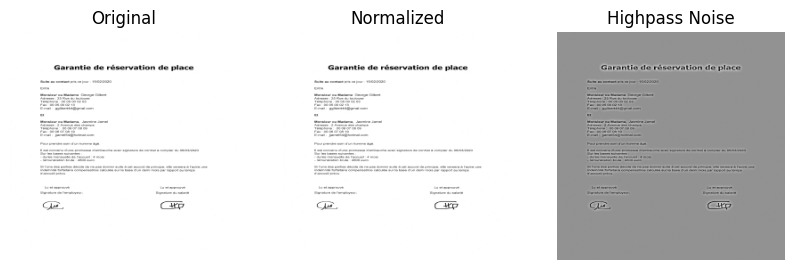

In [ ]:
# Block 5: Preprocessing helpers - normalize and compute high-pass (PRNU-like) noise
import cv2
import numpy as np
from matplotlib import pyplot as plt

def preprocess_image_gray(img):
    # img: uint8 grayscale
    img_f = img.astype(np.float32) / 255.0
    return img_f

def estimate_noise_highpass(img_f, ksize=7):
    # approximate sensor noise / PRNU by subtracting a denoised version (Gaussian blur)
    denoised = cv2.GaussianBlur(img_f, (ksize, ksize), 0)
    noise = img_f - denoised
    # normalize noise to [-1,1]
    std = noise.std() if noise.std() > 0 else 1e-6
    noise = noise / std
    return noise

# quick check on first image
if len(images) > 0:
    sample = images[0]
    sample_f = preprocess_image_gray(sample)
    sample_noise = estimate_noise_highpass(sample_f)
    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1); plt.title("Original"); plt.imshow(sample, cmap='gray'); plt.axis('off')
    plt.subplot(1,3,2); plt.title("Normalized"); plt.imshow(sample_f, cmap='gray'); plt.axis('off')
    plt.subplot(1,3,3); plt.title("Highpass Noise"); plt.imshow(sample_noise, cmap='gray'); plt.axis('off')


In [ ]:
# Block 6: Compute feature vector per image (FFT magnitude stats + LBP hist + highpass mean)
from skimage.feature import local_binary_pattern
import numpy as np

def fft_magnitude_stats(img_f):
    f = np.fft.fft2(img_f)
    fshift = np.fft.fftshift(f)
    mag = np.abs(fshift)
    # compute a few summary stats of magnitude spectrum (log scale)
    mlog = np.log1p(mag)
    return np.array([mlog.mean(), mlog.std(), np.percentile(mlog, 50), np.percentile(mlog, 90)])

def lbp_hist(img, P=8, R=1, n_bins=59):
    lbp = local_binary_pattern(img, P, R, method='uniform')
    # compute histogram over valid bins (uniform LBP gives P*(P-1)+3 bins typically; we will use n_bins)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    return hist

def build_feature_vector(img_uint8):
    img_f = preprocess_image_gray(img_uint8)
    # highpass noise
    noise = estimate_noise_highpass(img_f)
    high_mean = noise.mean()
    high_std = noise.std()
    # FFT stats
    fft_stats = fft_magnitude_stats(img_f)
    # LBP hist computed on resized smaller patch to speed up
    lbp_h = lbp_hist((img_uint8 / 255.0).astype(np.float32), P=8, R=1, n_bins=36)
    # concatenate
    feat = np.concatenate([ [high_mean, high_std], fft_stats, lbp_h ])
    return feat

# Build full feature matrix
features = []
for img in images:
    features.append(build_feature_vector(img))
features = np.vstack(features)
print("Feature matrix shape:", features.shape)


/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Feature matrix shape: (2200, 42)


In [ ]:
# Block 7: Encode labels and split train/test
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y_enc = le.fit_transform(labels)
X_train, X_test, y_train, y_test = train_test_split(features, y_enc, test_size=0.2, stratify=y_enc, random_state=42)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")
print("Classes:", list(le.classes_))




Train size: (1760, 42), Test size: (440, 42)
Classes: [np.str_('Canon120-1_150'), np.str_('Canon120-1_300'), np.str_('Canon120-2_150'), np.str_('Canon120-2_300'), np.str_('Canon220_150'), np.str_('Canon220_300'), np.str_('Canon9000-1_150'), np.str_('Canon9000-1_300'), np.str_('Canon9000-2_150'), np.str_('Canon9000-2_300'), np.str_('EpsonV370-1_150'), np.str_('EpsonV370-1_300'), np.str_('EpsonV370-2_150'), np.str_('EpsonV370-2_300'), np.str_('EpsonV39-1_150'), np.str_('EpsonV39-1_300'), np.str_('EpsonV39-2_150'), np.str_('EpsonV39-2_300'), np.str_('EpsonV550_150'), np.str_('EpsonV550_300'), np.str_('HP_150'), np.str_('HP_300')]


In [ ]:
features[1]

array([-6.32746378e-06,  1.00000000e+00,  1.99439716e+00,  6.73173249e-01,
        1.97044110e+00,  2.76391268e+00,  4.56237793e-03,  1.08642578e-02,
        2.15148926e-03,  2.03247070e-02,  1.31835938e-02,  1.72485352e-01,
        8.98742676e-03,  4.07409668e-02,  6.67297363e-01,  5.94024658e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])

🎯 RandomForest Accuracy: 46.59%

                 precision    recall  f1-score   support

 Canon120-1_150       0.36      0.45      0.40        20
 Canon120-1_300       0.40      0.50      0.44        20
 Canon120-2_150       0.15      0.15      0.15        20
 Canon120-2_300       0.39      0.35      0.37        20
   Canon220_150       0.41      0.60      0.49        20
   Canon220_300       0.75      0.75      0.75        20
Canon9000-1_150       0.29      0.25      0.27        20
Canon9000-1_300       0.08      0.10      0.09        20
Canon9000-2_150       0.12      0.10      0.11        20
Canon9000-2_300       0.07      0.05      0.06        20
EpsonV370-1_150       0.54      0.65      0.59        20
EpsonV370-1_300       0.56      0.45      0.50        20
EpsonV370-2_150       0.60      0.45      0.51        20
EpsonV370-2_300       0.54      0.70      0.61        20
 EpsonV39-1_150       0.17      0.10      0.12        20
 EpsonV39-1_300       0.57      0.40      0.47        

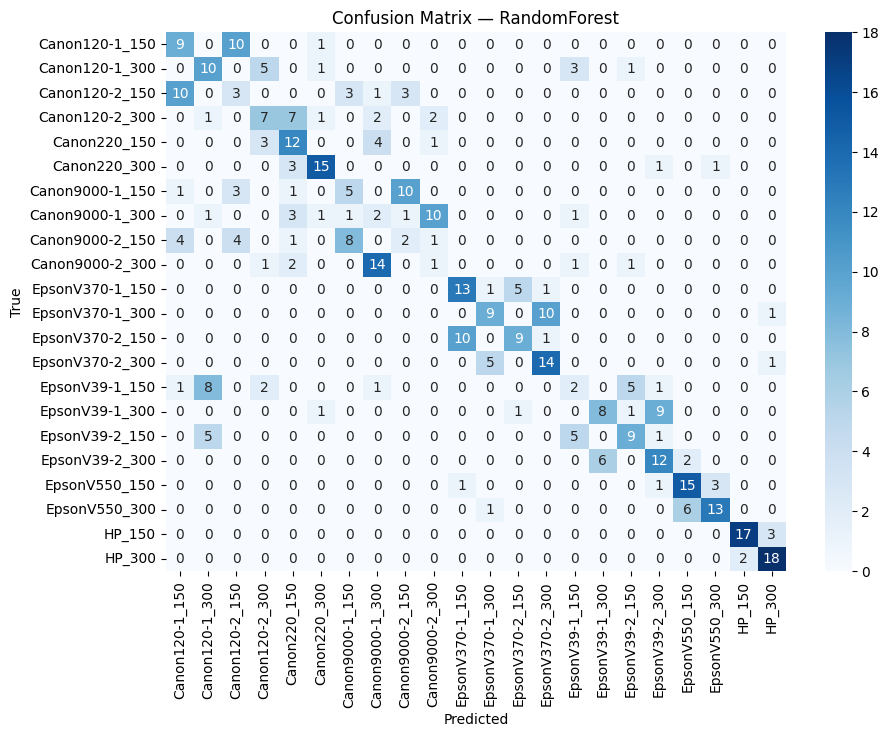

In [ ]:
# Block 8: Train RandomForest and evaluate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"🎯 RandomForest Accuracy: {acc*100:.2f}%\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix — RandomForest")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()


In [ ]:
# Block 9: Save model and encoder
import joblib
joblib.dump(clf, '/content/TraceFinder_RF_TIFF.joblib')
joblib.dump(le, '/content/TraceFinder_LabelEncoder.joblib')
print("✅ Saved: TraceFinder_RF_TIFF.joblib & TraceFinder_LabelEncoder.joblib")


✅ Saved: TraceFinder_RF_TIFF.joblib & TraceFinder_LabelEncoder.joblib


In [ ]:
# Block 10: Predict scanner source for a new .tif file
def predict_scanner(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Invalid image file.")
        return
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    feat = build_features(img).reshape(1, -1)
    pred = clf.predict(feat)[0]
    class_name = le.inverse_transform([pred])[0]
    probs = clf.predict_proba(feat)[0]
    confidence = np.max(probs) * 100
    print(f"🧾 Predicted Scanner: {class_name} ({confidence:.2f}% confidence)")

# Example usage:
# predict_scanner('/content/drive/MyDrive/Official_Dataset/canon220/150/sample_01.tif')


In [ ]:
# ======================================
# 1️⃣  INSTALL DEPENDENCIES
# ======================================
!pip install opencv-python numpy pandas scikit-learn tensorflow matplotlib seaborn streamlit shap tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 49.0 MB/s eta 0:00:00


In [ ]:
# ======================================
# 2️⃣  IMPORT LIBRARIES
# ======================================
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm



In [ ]:
# ======================================
# 3️⃣  DATASET SETUP
# ======================================
# Mount Google Drive if your dataset is stored there
from google.colab import drive
drive.mount('/content/drive')

# Example: Change this path to where your Flatfield dataset exists
DATASET_PATH = '/content/drive/MyDrive/Flatfield'

# Check structure
for root, dirs, files in os.walk(DATASET_PATH):
    print(root, "->", len(files), "files")
    break

# ======================================
# 4️⃣  LOAD AND PREPROCESS IMAGES
# ======================================
IMG_SIZE = 128
images, labels = [], []

for folder in os.listdir(DATASET_PATH):
    folder_path = os.path.join(DATASET_PATH, folder)
    if not os.path.isdir(folder_path): continue
    for file in tqdm(os.listdir(folder_path), desc=f"Loading {folder}"):
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif')):
            img = cv2.imread(os.path.join(folder_path, file), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img / 255.0
            images.append(img)
            labels.append(folder)

X = np.array(images).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(labels)

print("Total images:", len(X))
print("Classes:", np.unique(y))

# ======================================
# 5️⃣  ENCODE LABELS
# ======================================
le = LabelEncoder()
y_enc = le.fit_transform(y)
y_cat = to_categorical(y_enc)

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# ======================================
# 6️⃣  DATA AUGMENTATION
# ======================================
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.8, 1.2),
    zoom_range=0.1
)
datagen.fit(X_train)

# ======================================
# 7️⃣  CNN MODEL
# ======================================
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y)), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# ======================================
# 8️⃣  TRAIN MODEL
# ======================================
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=15,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

# ======================================
# 9️⃣  EVALUATE MODEL
# ======================================
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

loss, acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {acc*100:.2f}%")

# ======================================
# 🔟  SAVE MODEL
# ======================================
model.save('/content/TraceFinder_CNN.h5')
print("Model saved as TraceFinder_CNN.h5")

# ======================================
# 11️⃣  SIMPLE INFERENCE FUNCTION
# ======================================
def predict_scanner(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    img = img.reshape(1, IMG_SIZE, IMG_SIZE, 1)
    pred = model.predict(img)
    class_name = le.inverse_transform([np.argmax(pred)])[0]
    confidence = np.max(pred) * 100
    print(f"Predicted Scanner: {class_name} ({confidence:.2f}% confidence)")

# Example usage:
# predict_scanner("/content/drive/MyDrive/Flatfield/Epson/sample1.tif")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Flatfield -> 0 files


Loading EpsonV39-1:   0%|          | 0/3 [00:00<?, ?it/s]


error: OpenCV(4.12.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [ ]:
# ======================================
# 3️⃣  DATASET SETUP
# ======================================
# Mount Google Drive if your dataset is stored there
from google.colab import drive
drive.mount('/content/drive')

# Example: Change this path to where your Flatfield dataset exists
DATASET_PATH = '/content/drive/MyDrive/Flatfield'

# Check structure
for root, dirs, files in os.walk(DATASET_PATH):
    print(root, "->", len(files), "files")
    break



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Flatfield -> 0 files


In [ ]:
# ======================================
# 4️⃣  LOAD AND PREPROCESS IMAGES (SAFE VERSION)
# ======================================
IMG_SIZE = 128
images, labels = [], []

for folder in os.listdir(DATASET_PATH):
    folder_path = os.path.join(DATASET_PATH, folder)
    if not os.path.isdir(folder_path):
        continue

    for file in tqdm(os.listdir(folder_path), desc=f"Loading {folder}"):
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            # Skip unreadable or corrupted files
            if img is None:
                print(f"⚠️ Skipping unreadable file: {img_path}")
                continue

            try:
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                img = img / 255.0
                images.append(img)
                labels.append(folder)
            except Exception as e:
                print(f"⚠️ Error processing {file}: {e}")
                continue

X = np.array(images).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(labels)

print("✅ Total images loaded:", len(X))
print("✅ Classes found:", np.unique(y))


Loading EpsonV39-1:   0%|          | 0/3 [00:00<?, ?it/s]

⚠️ Skipping unreadable file: /content/drive/MyDrive/Flatfield/EpsonV39-1/._150.tif


Loading Canon120-1: 100%|██████████| 2/2 [00:05<00:00,  2.71s/it]

✅ Total images loaded: 22
✅ Classes found: ['Canon120-1' 'Canon120-2' 'Canon220' 'Canon9000-1' 'Canon9000-2'
 'EpsonV370-1' 'EpsonV370-2' 'EpsonV39-1' 'EpsonV39-2' 'EpsonV550' 'HP']


In [ ]:
# ======================================
# 5️⃣  ENCODE LABELS
# ======================================
le = LabelEncoder()
y_enc = le.fit_transform(y)
y_cat = to_categorical(y_enc)

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)



In [ ]:
# ======================================
# 6️⃣  DATA AUGMENTATION
# ======================================
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.8, 1.2),
    zoom_range=0.1
)
datagen.fit(X_train)



In [ ]:
# ======================================
# 7️⃣  CNN MODEL
# ======================================
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y)), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,393,163 (28.20 MB)

 Trainable params: 7,393,163 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ======================================
# 8️⃣  TRAIN MODEL
# ======================================
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=15,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1765 - loss: 2.4150 - val_accuracy: 0.0000e+00 - val_loss: 9.8401
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0588 - loss: 6.2174 - val_accuracy: 0.0000e+00 - val_loss: 8.5155
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.1765 - loss: 3.6038 - val_accuracy: 0.0000e+00 - val_loss: 5.8926
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step - accuracy: 0.0000e+00 - loss: 3.5195 - val_accuracy: 0.0000e+00 - val_loss: 4.4642
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.0588 - loss: 2.9981 - val_accuracy: 0.0000e+00 - val_loss: 4.2102
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step - accuracy: 0.1765 - loss: 2.4074 - val_accuracy: 0.0000e+00 - val_loss: 3.9425
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step - accuracy: 0.0588 - loss: 2.7111 - val_accuracy: 0.0000e+00 - val_loss: 3.6107
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step - accuracy: 0.1176 - loss: 2.5407 - val_accuracy: 0.0

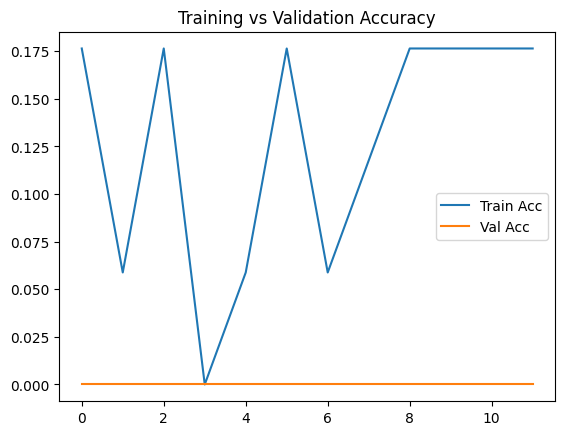

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.0000e+00 - loss: 2.8515
✅ Test Accuracy: 0.00%


In [ ]:
# ======================================
# 9️⃣  EVALUATE MODEL
# ======================================
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

loss, acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {acc*100:.2f}%")

In [ ]:
# ======================================
# 🔟  SAVE MODEL
# ======================================
model.save('/content/TraceFinder_CNN.h5')
print("Model saved as TraceFinder_CNN.h5")

Model saved as TraceFinder_CNN.h5


In [ ]:
# ======================================
# 11️⃣  SIMPLE INFERENCE FUNCTION
# ======================================
def predict_scanner(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    img = img.reshape(1, IMG_SIZE, IMG_SIZE, 1)
    pred = model.predict(img)
    class_name = le.inverse_transform([np.argmax(pred)])[0]
    confidence = np.max(pred) * 100
    print(f"Predicted Scanner: {class_name} ({confidence:.2f}% confidence)")

# Example usage:
# predict_scanner("/content/drive/MyDrive/Flatfield/Epson/sample1.tif")